<h1> <center> State space Model </center> </h1>
### a) description

Given some observable random vectors $Y_t$ we have this structure for the state model, where $\theta-t$ is the hidden state variable.

![state space](state_space.png)

Where we assume this two properties:

1) $(\theta_t, t =0,1,...)$ is a Markov Chain. Thus, the probability law of the process is specified by assigning the initial density $p_0(\theta_0)$ and the transaction densities $p(\theta_t|\theta_{t-1})$

2) Conditionally  on $\theta_t$ the $Y_t$'s are independent and $Y_t$ depends on $\theta_t$ only. It follows that for any $n \geq 1$,  $\quad(Y_1, ... , Y_n)| \theta_1, ... , \theta_n \sim \prod_{t=1}^{n} \; f(y_t|\theta_t)$

The term *state-space model* is used when the state variables are continuous, when they are discrete, one usually calls this model a *hidden Markov model*.

Given the structure above and the properties 1 and 2, we can write the join d.f. as:

$$(\theta_0,\theta_1,...,\theta_n, Y_1,...,Y_n)\sim p_0(\theta_0) \cdot \prod_{t=1}^n \; f(Y_t| \theta_t) p(\theta_t | \theta_{t - 1}) $$

.


### b) Dynamic Linear Models

The first, important class of state-space models is given by Gaussian linear state-space models, also called DLM. These models are specified by means of two equations:

$$\vec Y_t = F_t \cdot \vec \theta_t  + \vec v_t,  \quad  \vec v_t \sim N_m(0, V_t),$$
$$\vec \theta_t = G_t \cdot \vec \theta_{t -1} + \vec w_t, \quad \vec w_t \sim N_p(0, W_t)$$.

Furthermore, it is assumed that $\theta_0$ has a Gaussian distribution, $\vec \theta_0 \sim N_p(m_0,C_0)$.

###### One dimension Random Walk plu noise
$$Y_t = \mu_t + v_t, \quad v_t \sim N(0,V = 1.4), \quad (F=1)$$,
$$\mu_t = \mu_{t - 1} + w_t, \quad w_t \sim N(0,W=0.2), \quad (G=1)$$

.

###### Linear Growt Model
$$Y_t = \mu_t + v_t, \quad v_t \sim N(0,V)$$
$$\mu_t = \mu_{t-1} + \beta_{t-1} + w_{1,t}, \quad w_{1,t} \sim N(0,\sigma^2_{w_1})$$
$$\beta_t = \beta_{t-1} + w_{2,t}, \quad w_{2,t} \sim N(0,\sigma^2_{w_2})$$
with:
    $$\vec \theta_t = \begin{pmatrix} \mu_t \\ \beta_t \end{pmatrix}, \quad G=\begin{pmatrix} 1 & 1 \\ 0 & 1 \end{pmatrix},\quad  W = \begin{pmatrix} \sigma^2_{w_1} & 0 \\ 0 & \sigma^2_{w_1} \end{pmatrix} \quad F = \begin{pmatrix} 1 &  0 \end{pmatrix} $$
    
    
###### Simple Dynamic Regression

$$Y_t = \theta_{1,t} + \theta_{2,t}\cdot x_t + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2_t)$$;
$$\vec \theta_t = G_t \cdot \vec \theta_{t-1} + \vec w_t, \quad \vec w_t \sim N_2(0,W_t)$$

with, $F_t = (1, x_t)$

In [2]:
require(dlm, quietly = T)
# one dimension random walk plus noise
rw <- dlm(m0 = 0, C0 = 10 , FF=1, V=1.4, GG=1, W=0.2)



# Linear growt Model
lg <- dlm(m0=rep(0,2), C0 = 10*diag(2), FF=matrix(c(1,0), nrow = 1), V=1.4,
          GG= matrix(c(1,0,1,1), nrow = 2), W=diag(c(0,0.2))    )


# Dynamic Linear Regression
x <- rnorm(100) # covariates
dlr <- dlm(m0=rep(0,2), C0 = 10*diag(2), FF=matrix(c(1,0), nrow = 1), V=1.3,
           GG= diag(2), W=diag(c(0.4,0.2)), 
           JFF=matrix(c(0,1), nrow = 1), X=as.matrix(x))


In [3]:
unlist(rw)

m0   C0   FF    V   GG    W 
 0.0 10.0  1.0  1.4  1.0  0.2

## State estimation and forecasting

For estimating the state vector we can compute the conditional posterior densities $p(\theta_s | y_1, ..., y_t)$. We distinguish between problems of *filtering* (when s = t), *state prediciton* (s >t) and *smoothing* (s<t).
    
    I will present just filtering and prediction

### Prediction Filtering
We first describe the recursive steps for computing the filtering densities $p(\theta_t| Y_1, ...,Y_t)$ in general state space models. 
So let's me introduce the **recursive algorithm** used for prediction and filtering:

1) The one-step-ahead predictive density for the states can be computed from the filtered density $p(\theta_t| D_{t-1})$ according to:
$$p(\theta_t| D_{t-1}) = \int p(\theta_t|\theta_{t-1}) \; p(\theta_{t_1}| D_{t-1}) \; dv(\theta_{t-1})$$

2) The one-step-ahead predictive density for the observations can be computed from the predictive density for the states as:
$$p(y_t| D_{t-1}) = \int f(y_t|\theta_{t}) \; p(\theta_{t}| D_{t-1}) \; dv(\theta_{t})$$

3) The filtering density can be computed from the above densities as:
$$p(\theta_t | D_t) = \frac{f(y_t|\theta_t)\; p(\theta_t| D_{t-1})}{p(y_t|D_{t-1})}$$



##### The Kalman filter for DLM
The previous results solve in principle the filtering and the forecasting problem, howover in general the actual computation of the relevant conditional densities is not an easy task. But using standards results about the multivariate Gaussian distribution, absuming the join distribution as Gaussian, then all the marginals and the conditionals are also Gaussian, and since the relevant d.f. are gaussian, it suffices to compute their means and covariance, to have the solution of the filtering problem, this is known as **kalman filter**, so:

If $\theta_{t-1}|D_{t-1} \sim N(m_{t-1},C_{T-1})\quad $ where $t \geq 1$, then:

1) the one-step-ahead state predictive distribution of $\theta_t| D_{t-1}$, is Gaussian with parameters
$$a_t = E(\theta_t| D_{t-1})= G_t \cdot m_{t-1}$$
$$R_t = Var(\theta_t| D_{t-1}) = G_t\cdot C_{t-1} \cdot G^{'}_t + W_t $$

2) The  one-step-ahead predictive distribution of $Y_t | D_{t-1}$, is Gaussian with parameters
$$f_t = E(Y_t | D_{t-1})= F_t \cdot a_t$$
$$Q_t = Var(Y_t | D_{t-1}) = F_t\cdot R_{t} \cdot F^{'}_t + V_t$$

3) The filterind density of $\theta_t | D_t$ is Gaussian with:
$$m_t = E(\theta_t|D_t) = a_t + R_t\cdot F^{'}_t \cdot Q^{-1}_t \cdot \epsilon_t$$
$$C_t = Var(\theta_t|D_t) = R_t - R_t \cdot F^{'}_t\cdot Q^{-1}_t \cdot F_t \cdot R_t$$
    where $\epsilon_t = Y_t - f_t$ is the forecast error.


.


.


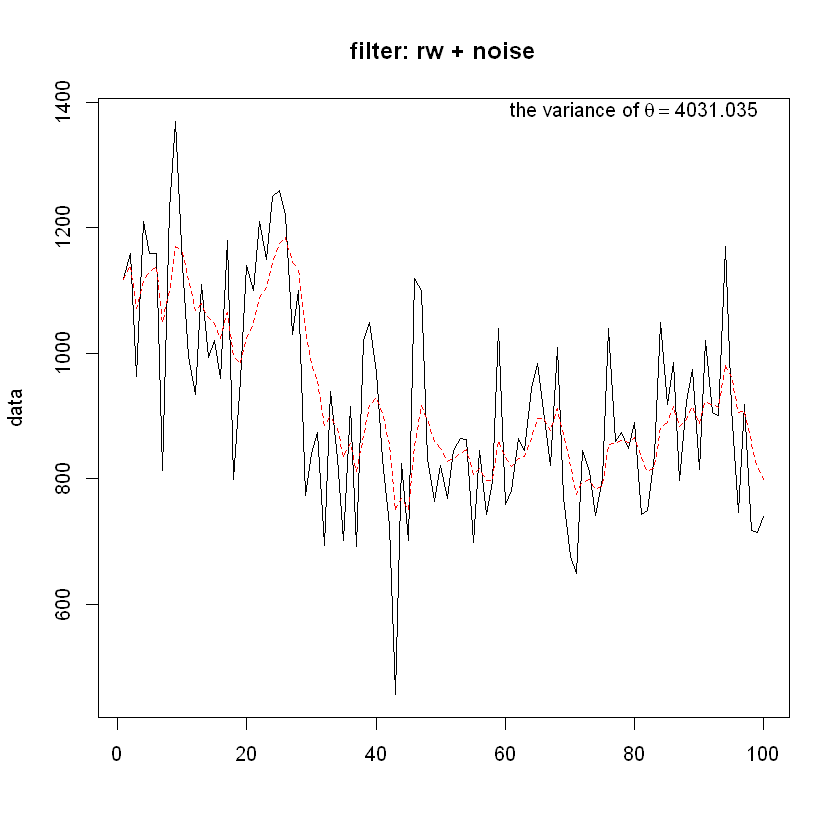

In [4]:
#random walk with noise example
mod <- dlmModPoly(order = 1, dV=15100, dW = 1468) #dV and dW are MLE.

# filtering the data
modFilt <- dlmFilter(Nile, mod)
data <- data.frame(Nile, modFilt$m[-1]) # -1 since there is theta0
matplot(data, type='l', main= 'filter: rw + noise')
v <- with(modFilt,dlmSvd2var(U.C[[101]], D.C[[101]]))
text(80,1390,bquote('the variance of'~ theta == .(v)))

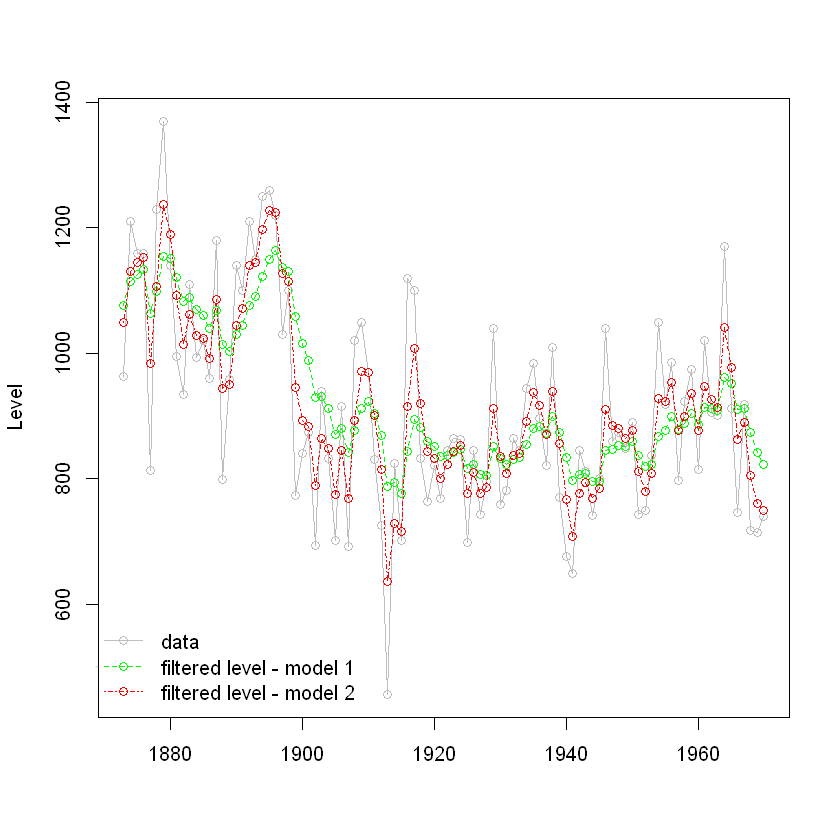

In [5]:
mod1 <- dlmModPoly(order = 1, dV = 15100, dW=0.5*1468) # W/V signal noise ratio is 10 times less 
nileFilt1 <- dlmFilter(Nile, mod1)
plot(window(cbind(Nile,nileFilt1$m[-1]),start=start(Nile)+1), plot.type='s',
     type='o', col=c("grey","green"), lty=c(1,2), xlab="", ylab="Level")
mod2 <- dlmModPoly(order = 1, dV = 15100, dW = 5 * 1468)  #signal noise ratio 10 times more
nileFilt2 <- dlmFilter(Nile, mod2)
lines(window(nileFilt2$m,start=start(Nile)+1), type='o', col="red", lty=4)
legend("bottomleft", legend=c("data", "filtered level - model 1",
                              "filtered level - model 2"),
       col=c("grey", "green", "red"), lty=c(1,2,4), pch=1, bty='n')

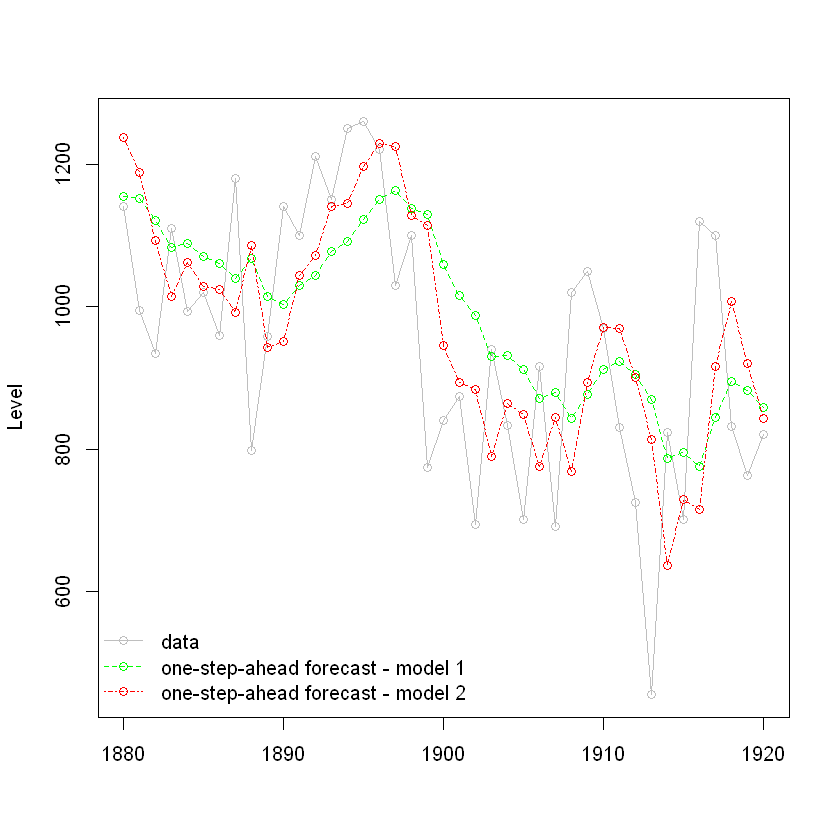

In [6]:
plot(window(cbind(Nile, nileFilt1$f, nileFilt2$f), start=1880, end=1920),
plot.type='s', type='o', col=c("grey", "green", "red"), lty=c(1,2,4),xlab="", ylab="Level")
legend("bottomleft", legend=c("data", paste("one-step-ahead forecast - model", 1:2)),
       col=c("grey", "green", "red"), lty=c(1,2,4), pch=1, bty='n')

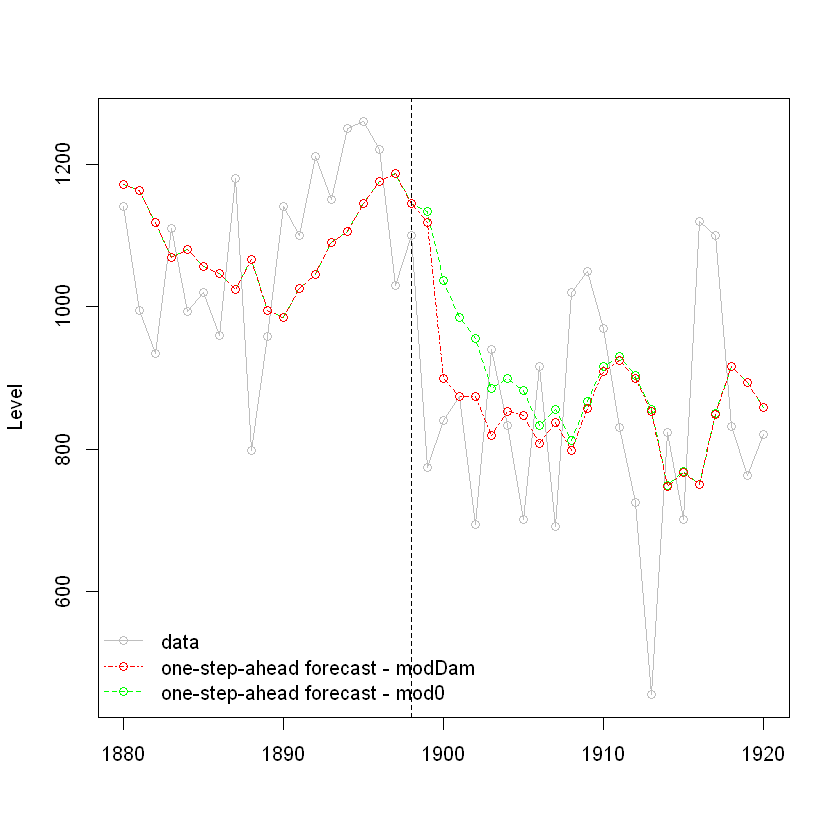

In [7]:
mod0 <- dlmModPoly(order = 1, dV = 15100, dW = 1468)
X <- ts(matrix(mod0$W, nc=1, nr=length(Nile)), start=start(Nile))
window(X, 1898, 1899) <- 12 * mod0$W
modDam <- mod0
modDam$X <- X
modDam$JW <- matrix(1,1,1)
damFilt <- dlmFilter(Nile, modDam)
mod0Filt <- dlmFilter(Nile, mod0)
plot(window(cbind(Nile, mod0Filt$f, damFilt$f), start=1880, end=1920),
     plot.type='s', type='o', col=c("grey", "green", "red"),
     lty=c(1,2,4), xlab="", ylab="Level")
abline(v=1898, lty=2)
legend("bottomleft", col=c("grey", "red", "green"), lty=c(1,4,2), pch=1, bty='n',
       legend=c("data", paste("one-step-ahead forecast -", c("modDam", "mod0"))))